In [4]:
import pymc3 as pm
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
from theano import shared,tensor
import time 
from datetime import datetime
from sklearn.metrics import mean_squared_error
import pickle
import joblib

#### 讀訓練和測試資料

In [5]:
df=pd.read_csv('/Users/pryang/Documents/貝氏資料分析介紹/Project/Bayesian-Final/EPA_OD_202304.csv')
truth=pd.read_csv('/Users/pryang/Documents/貝氏資料分析介紹/Project/Bayesian-Final/EPA_OD_202305.csv')
df=df[df['PublishTime']>='2023-04-28 00:00:00']
df.head()

,SiteName,County,AQI,Pollutant,Status,SO2,CO,CO_8hr,O3,O3_8hr,...,NO2,NOx,NO,WindSpeed,WindDirec,PublishTime,SO2_AVG,Longitude,Latitude,SiteId
48664,金門,金門縣,70.0,細懸浮微粒,普通,2.9,0.27,0.2,50.3,58.3,...,6.4,6.7,0.3,1.9,82,2023-04-28 00:00:00,2.0,118.312256,24.432133,77
48665,埔里,南投縣,59.0,細懸浮微粒,普通,1.0,0.37,0.3,34.1,NaN,...,7.4,8.8,1.4,0.3,319,2023-04-28 00:00:00,1.0,120.967903,23.968842,72
48666,宜蘭,宜蘭縣,37.0,NaN,良好,0.5,0.26,0.2,24.8,40.7,...,5.1,5.4,0.2,0.5,252,2023-04-28 00:00:00,0.0,121.746394,24.747917,65
48667,永和,新北市,57.0,二氧化氮,普通,0.8,1.87,1.0,0.7,15.1,...,39.2,79.5,40.3,0.2,295,2023-04-28 00:00:00,0.0,121.516306,25.017000,70
48668,富貴角,新北市,44.0,NaN,良好,0.8,0.20,0.1,35.9,48.9,...,3.4,3.4,0.0,1.9,147,2023-04-28 00:00:00,0.0,121.536569,25.296817,84


#### 資料集有缺失資料

In [6]:
features=['PM2.5_AVG','PM10','PM2.5','SiteId']
for feature in features:
    print(f"{feature} has nan value: ",df[feature].isna().any())

PM2.5_AVG has nan value:  True
PM10 has nan value:  True
PM2.5 has nan value:  True
SiteId has nan value:  False


#### 資料前處理：處理空白值

In [7]:
def preprosessing(data):
    data=data.fillna(method='ffill')
    return data
df=preprosessing(df)

#### 資料前處理：標準化

In [8]:
def standardize(data):
    for feature in features[:-2]:
        data[feature] =( data[feature] - data[feature].mean() ) / data[feature].std()
    return data
df=standardize(df)

#### 訓練Hierarchical Linear Regression Model

In [9]:
with pm.Model() as model:
    ## hyper prior
    alpha_mean=pm.Normal('alpha_p',mu=0,sd=10)
    alpha_sd=pm.HalfNormal('alpha_sd',sd=10)
    beta_mean=pm.Normal('beta_p',mu=0,sd=10)
    beta_sd=pm.HalfNormal('beta_sd',sd=10)
    
    X0=pm.Data('X0',df[features[0]])
    X1=pm.Data('X1',df[features[1]])
    y=pm.Data('y',df[features[2]])
    alpha=pm.Normal('alpha',mu=alpha_mean,sd=alpha_sd)
    beta=pm.Normal('beta',mu=beta_mean,sd=beta_sd,shape=2)
    esp=pm.HalfNormal('esp',sd=10)
    
    mu=pm.Deterministic('mu',alpha+beta[0]*X0+beta[1]*X1)
    y_pred=pm.Normal('y_pred',mu=mu,sd=esp,observed=y)
    trace=pm.sample()
    ppc=pm.sample_posterior_predictive(trace)

/Users/pryang/opt/anaconda3/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [esp, beta, alpha, beta_sd, beta_p, alpha_sd, alpha_p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 106 seconds.
There were 292 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7040817049574581, but should be close to 0.8. Try to increase the number of tuning steps.
There were 285 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6123738989748897, but should be close to 0.8. Try to increase the number of tuning steps.
There were 214 divergences after tuning. Increase `target_accept` or reparameterize.
There were 253 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7089056982362737, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during s

#### 利用模型結果預測PM2.5

In [10]:
def calculate_result(row):
    site=int(row['SiteId'])
    a=trace['alpha'].mean()
    b0=trace['beta'][0].mean()
    b1=trace['beta'][1].mean()
    result = a + b0 * row[features[0]]+  b1 * (row[features[0]]**2)
    return result
df['result'] = df.apply(calculate_result, axis=1)

#### Training Data MSE

In [11]:
mse = mean_squared_error(df['PM2.5'].values, df['result'].values)
print("training mse:",mse)

training mse: 91.91740952160083


#### Testing Data MSE

In [12]:
truth=preprosessing(truth)
truth=standardize(truth)
truth['result'] = truth.apply(calculate_result, axis=1)
mse = mean_squared_error(truth['PM2.5'].values, truth['result'].values)
print("testing mse:",mse)

testing mse: 114.91585948850593


#### Posterior Predictive Check

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/pryang/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


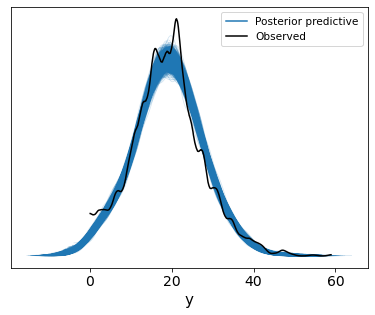

In [13]:
az.plot_ppc(az.from_pymc3(trace,posterior_predictive=ppc),mean=False)
plt.xlabel('y')
plt.savefig("posterior predictive")

#### R Square

In [14]:
print("for training data:")
print(az.r2_score(df['PM2.5'].values, df['result'].values))
print()
print("for testing data:")
print(az.r2_score(truth['PM2.5'].values, truth['result'].values))

for training data:
r2        0.400857
r2_std    0.000000
dtype: float64

for testing data:
r2        0.595926
r2_std    0.000000
dtype: float64


#### Expected Log Pointwise Density

In [15]:
elpd=az.loo(trace,pointwise=True,scale="deviance")
elpd

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/pryang/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/pryang/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 3773 observations log-likelihood matrix.

             Estimate       SE
deviance_loo 20757.36   115.41
p_loo            5.44        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3770   99.9%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         3    0.1%
   (1, Inf)   (very bad)    0    0.0%

#### Save Trace and Posterior Predictive

In [16]:
pklname="trace"+".pkl"
pklppc="predict"+".pkl"
with open(pklname, 'wb') as file:
    pickle.dump(trace, file)
with open(pklppc,'wb') as file:
    pickle.dump(ppc,file)

#### Save Model

In [17]:
filename = "hier_model.joblib"
joblib.dump(model, filename)

['hier_model.joblib']